## Need to make these functions:
1. Convert dict of lists into graphviz and visulalize (not sure if should be seperate or not)
2. Make complete graph
3. make linear graph
4. make polygon graph
5. make star graph
6. make lollipop graph
7. make generalized star graph
8. make random graph with n vertices, m edges 

In [1]:
import numpy as np
import graphviz
import random
import shutil
import cairosvg
from PIL import Image
from IPython.display import IFrame
from IPython.display import SVG, display

In [51]:
def make_complete_graph(n):
    dict = {}
    for i in range(n):
        dict[i] = []
        for j in range(n-1):
            dict[i].append((i + j + 1) % n)
    return dict\


def make_cycle_graph(n):
    dict = {}
    for i in range(n):
        dict[i] = []
        dict[i].append((i + 1) % n)
        dict[i].append((i - 1) % n)
    return dict

def make_linear_graph(n):
    dict = {}
    for i in range(n-1):
        dict[i] = []
        dict[i].append(i + 1)
    dict[n-1] = []
    for i in range(n-1):
        dict[i+1].append(i)
    return dict

In [34]:
def create_gif(svg_files, output_gif, length = 10):
    """Creates a GIF from a list of SVG files."""

    # Convert SVGs to PNGs
    png_files = []
    for svg_file in svg_files:
        png_file = svg_file.replace('.svg', '.png')
        cairosvg.svg2png(url=svg_file, write_to=png_file)
        png_files.append(png_file)

    # Create GIF using PIL
    images = [Image.open(png_file) for png_file in png_files]
    images[0].save(
        output_gif, 
        save_all=True, 
        append_images=images[1:], 
        optimize=False, 
        duration= int((length * 1000) / len(svg_files)), 
        loop=0 
    )

# want to create tmp folder of svg files then once we have a gif delete that 



In [47]:
class Graph(object):

    def __init__(self, n, graph_type):
        # Assume fd is a file-like object.
        self.n = n
        self.graph_type = graph_type
        self.engine = self.map_engine()
        self.dict = self.get_graph_dict()
        self.graphviz = self.make_graphviz()
        

    def from_filename(cls, name):
        return cls(open(name, 'rb'))

    def get_graph_dict(self):
        if self.graph_type == "complete":
            return make_complete_graph(self.n)
        elif self.graph_type == "cycle":
            return make_cycle_graph(self.n)
        elif self.graph_type == "linear":
            return make_linear_graph(self.n)

    def map_engine(self):
        engine_dict = {"complete": "circo", "cycle": "circo", "linear": "dot"}
        return engine_dict[self.graph_type] if self.graph_type in engine_dict.keys() else "neato"

    # develop flags for different types of graphs like an int flag
    def make_graphviz(self):
        
        g = graphviz.Graph(engine = self.engine) #
        keys = list(self.dict.keys())
        visited = []

        g.attr('node', width='0.4', height='0.4', fixedsize='true', fontsize='8')
        
        if self.graph_type == "linear":
            g.attr(rankdir='LR')  # Left to Right layout

        for i in range(len(keys)):
            a = keys[i]
            for j in range(len(self.dict[a])):
                if (self.dict[a][j], a) not in visited:
                    g.edge(str(a), str(self.dict[a][j]))
                    visited.append((a, self.dict[a][j]))
        return g

    def make_path_gif(self, path = None):
        if path == None:
            path = g.cover_walk()


        # if not there, regular
        # if there and filled in:
        # gray and 
        #self.graphviz.node('2', color = 'green', style = 'filled', fillcolor='gray', penwidth = '3')
        #self.graphviz.node('3', style = 'filled', fillcolor='gray')
        #self.graphviz.node('4', color = 'green', penwidth = '3')

        #svg_path = 'temp'
        filepaths = []
        visited = set()

        for i in range(len(path)):
            svg_path = 'temp/' + str(i)
            filepaths.append(svg_path + '.svg')

            #current point
            if path[i] not in visited:
                self.graphviz.node(str(path[i]), color = 'green', penwidth = '3')

                self.graphviz.render(svg_path, format='svg', cleanup=True)


                visited.add(path[i])

            else:
                self.graphviz.node(str(path[i]), color = 'green', style = 'filled', fillcolor='gray', penwidth = '3')
                                   
                self.graphviz.render(svg_path, format='svg', cleanup=True)

            self.graphviz.node(str(path[i]), style = 'filled', fillcolor = 'gray', color = 'black', penwidth = '1')

        for vertex in visited:
            self.graphviz.node(str(vertex), color = 'black', fillcolor = 'transparent', penwdith = '1')
        
            #self.graphviz.node(str(path[i]), color = 'black', penwidth = '1')

        
        
        create_gif(filepaths, "output.gif", self.n)

        shutil.rmtree("temp")

        # at the end make all vertices normal again
    
    def display(self):
        svg_path = 'temp'
        self.graphviz.render(svg_path, format='svg', cleanup=True)
        display(SVG(svg_path + ".svg"))

    def cover_walk(self, starting_vertex = None):
        if (starting_vertex == None):
            starting_vertex = 0

        if (starting_vertex < 0 or starting_vertex > self.n):
            raise ValueError("The starting vertex cannot be negative or higher than n.")
   
        path = []
        visited = set()

        cur = starting_vertex

        while len(visited) != self.n:
            next_vertex = random.choice(self.dict[cur])
            path.append(next_vertex)
            visited.add(next_vertex)

            cur = next_vertex

        print("Cover Time: " + str(len(path)))
        return path


    # make partial cover walk for time to reach n unique vertices

    # make avergaging functions for this where it runs it a bunch
        

            

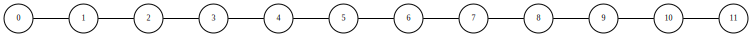

In [53]:
g = Graph(12, "linear")
g.display()

In [56]:
g.make_path_gif()

Cover Time: 87


In [7]:
g.cover_walk()

Cover Time: 13
[3, 2, 0, 3, 0, 4, 2, 3, 0, 2, 4, 2, 1]


[3, 2, 0, 3, 0, 4, 2, 3, 0, 2, 4, 2, 1]